In [1]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt

In [56]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt
from urllib.parse import urlparse, urljoin

def extract_links(url, main_domain):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    links = []
    for a in soup.find_all('a', href=True):
        link = a.get('href')
        if link:
            absolute_url = urljoin(url, link)
            parsed_url = urlparse(absolute_url)
            # Check if the link belongs to the main domain
            if parsed_url.scheme !='mailto':
                # faut il explorer les autres pages d'un même domain ou mettre un filtre
                # main_domain != parsed_url.netloc ?
                links.append(absolute_url)
    
    return links

def build_network(seed_url, depth, domain_to_exclude=[], graph=None):
    if graph is None:
        graph = nx.Graph()

    if depth == 0:
        return graph

    try:
        domain = urlparse(seed_url).netloc
        links = extract_links(seed_url, domain)
        for link in links:
            linked_domain = urlparse(link).netloc
            if not(linked_domain in domain_to_exclude):
                if domain != linked_domain:
                    if graph.has_edge(domain, linked_domain):
                        graph[domain][linked_domain]['weight'] += 1
                    else:
                        graph.add_edge(domain, linked_domain, weight = 1)
                build_network(link, depth - 1, domain_to_exclude, graph)
    except requests.exceptions.RequestException as e:
        print(f"Error processing {seed_url}: {e}, for domain : {urlparse(seed_url)}, for URL : {seed_url}, for depth : {depth}")

    return graph

In [75]:
recompute = True
nodes_to_exclude = [
    'www.helloasso.com',
    "www.youtube.com",
    "www.facebook.com",
    "www.instagram.com",
    "twitter.com",
    "www.tumblr.com",
    "pinterest.com",
    "www.tiktok.com",
    "www.linkedin.com",
    "play.google.com",
    "apps.apple.com",
    "support.google.com",
    "support.microsoft.com",
    'support.apple.com',
    "support.mozilla.com"
]

list_seed_website = [
    'https://www.lesyndicatdelafamille.fr/',
    'https://www.observatoirepetitesirene.org',
    'https://www.parti-reconquete.fr/'
]

depth_of_network = 2
if recompute:
    list_graph = []
for seed_website in list_seed_website:
    list_graph.append(build_network(seed_website, depth_of_network, nodes_to_exclude))

network_graph = nx.compose_all(list_graph)

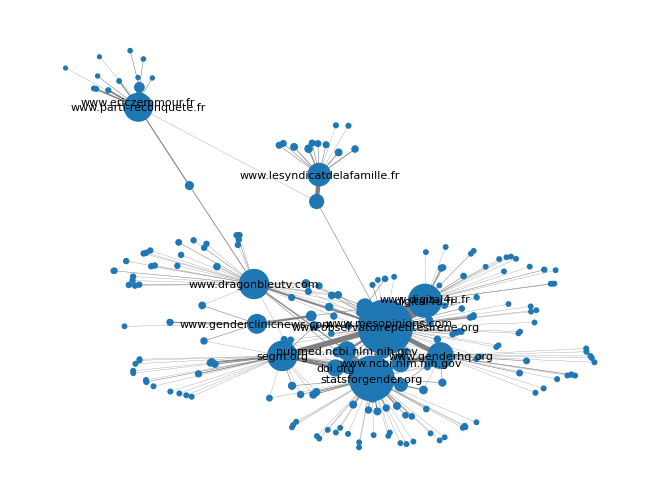

In [78]:
# Nodes to exclude from the calculation

# Calculate PageRank scores excluding specified nodes
pagerank_scores_with_exclusion = nx.pagerank(network_graph.subgraph(set(network_graph.nodes) - set(nodes_to_exclude)))
pagerank_scores = pagerank_scores = nx.pagerank(network_graph)
# Get the top 10 nodes based on PageRank scores
n_top_nodes = 15
top_nodes = sorted(pagerank_scores_with_exclusion, key=pagerank_scores.get, reverse=True)[:n_top_nodes]

# Visualization with different edge sizes based on weights and labels of the top 10 nodes
pos = nx.spring_layout(network_graph, k=0.01)
edge_widths = [network_graph[u][v]['weight'] for u, v in network_graph.edges()]

# Scale down the edge widths (adjust the scaling factor as needed)
edge_widths = [width * 0.2 for width in edge_widths]

node_sizes = [pagerank_scores[node] * 10000 for node in network_graph.nodes()]

nx.draw(network_graph, pos, with_labels=False, font_weight='bold', width=edge_widths, node_size = node_sizes, edge_color='gray')

# Display labels of the top 10 nodes
labels = {node: node if node in top_nodes else '' for node in network_graph.nodes}
nx.draw_networkx_labels(network_graph, pos, labels=labels, font_size=8)

plt.show()

In [90]:
G = nx.random_geometric_graph(200, 0.125)
nx.set_node_attributes(network_graph, pos, 'pos')
# Add positions to the graph as node attributes
G = network_graph
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()